##Imports and format NB

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import preprocessing

import statsmodels.api as sm
from patsy import dmatrices
from IPython.display import display


from google.colab import drive


In [243]:
pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)

# Функції

In [244]:
def predict_and_plot(X_train, train_targets, name=''):
    preds = model.predict(X_train)

    accuracy = accuracy_score(train_targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(train_targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

In [245]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds)
  print(f"F1 score {name}: {f1_score_:.2f}%")


In [246]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

In [247]:
def predict_zero(X):
    return np.zeros(X.shape[0], dtype=int)

#1

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

##Read dataframe

In [248]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [283]:
df = pd.read_csv('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/train.csv.zip')

##Data

In [284]:
df.head(5)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.00,Nwankwo,678.00,France,Male,29.00,4.00,0.00,3.00,1.00,0.00,180626.36,0.00
1,1,15650086.00,Ch'in,687.00,France,Female,34.00,1.00,0.00,2.00,0.00,1.00,63736.17,0.00
2,2,15733602.00,Thompson,682.00,France,Female,52.00,6.00,0.00,3.00,0.00,0.00,179655.87,1.00
3,3,15645794.00,Macleod,753.00,Germany,Male,44.00,6.00,83347.25,2.00,1.00,0.00,161407.48,0.00
4,4,15633840.00,Hsia,544.00,Germany,Female,55.00,0.00,107747.57,1.00,1.00,0.00,176580.86,1.00


In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [286]:
#перетворення колонки ID в str
#df['id'] = df['id'].astype(str)

Видалення колонок. В описі даних було вказано видалити колонку CustomerId. Також прізвище клієнта не доцільно оцифровувати, бо припускаю, що прізвище не може слугувати унікальним ідентифікатором і свідчити про звязок між клієнтами, а саме по собі прізвище не впливає на таргет.

In [287]:
df = df.drop(columns=['CustomerId', 'Surname'])

In [288]:
df.describe()


,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,7499.50,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67,0.20
std,4330.27,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45,0.40
min,0.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,3749.75,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14,0.00
50%,7499.50,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87,0.00
75%,11249.25,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70,0.00
max,14999.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.00


##Deviding for datasets

In [289]:
df.columns

Index(['id', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [290]:
input = ['id', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember','EstimatedSalary']
input_cols = df[input]
target_col = df['Exited']

In [291]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(input_cols, target_col, test_size=0.2, random_state=12, stratify=target_col)

#2

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [ ]:
#викоанно вище в першому завданні

#3

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [293]:
asis_col = ['id']
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.difference(asis_col).tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

#4

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

Числові колонки

In [294]:
#Числові колонки
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

Категоріальні колонки

In [295]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [296]:
display(train_inputs.head(5))

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
3709,3709,0.45,Germany,Female,0.29,0.10,0.63,0.33,1.00,1.00,0.90,0.00,1.00,0.00,1.00,0.00
5745,5745,0.44,Germany,Male,0.41,0.30,0.48,0.33,1.00,1.00,0.68,0.00,1.00,0.00,0.00,1.00
3602,3602,0.50,France,Male,0.27,0.10,0.72,0.00,1.00,0.00,0.37,1.00,0.00,0.00,0.00,1.00
925,925,0.70,France,Male,0.27,0.10,0.00,0.33,1.00,1.00,0.92,1.00,0.00,0.00,0.00,1.00
11868,11868,0.23,France,Female,0.25,0.10,0.51,0.00,0.00,1.00,0.79,1.00,0.00,0.00,1.00,0.00


In [297]:
display(val_inputs.head(5))

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
12482,12482,0.39,Spain,Male,0.23,0.80,0.00,0.33,1.00,0.00,0.33,0.00,0.00,1.00,0.00,1.00
12440,12440,0.66,France,Female,0.36,0.30,0.00,0.33,0.00,0.00,0.70,1.00,0.00,0.00,1.00,0.00
5402,5402,0.61,Germany,Male,0.29,0.20,0.51,0.00,1.00,1.00,0.85,0.00,1.00,0.00,0.00,1.00
3588,3588,0.57,France,Female,0.39,0.60,0.00,0.00,1.00,1.00,0.63,1.00,0.00,0.00,1.00,0.00
11109,11109,0.38,France,Male,0.38,0.00,0.53,0.00,0.00,1.00,0.37,1.00,0.00,0.00,0.00,1.00


**Пояснення:**
1. Використала MinMaxScaler для масштабування числових даних, бо у нас є колонки і діапазон 0-1 краще підходить
2. Дані про стать опрацювала як бінарну категорію, щоб не створювати додатково невиправдані колонки
3. Дані про країну опрацювала OnehotEncoder, оскільки більше аніж одна колонка.
4. видалила з обох наборів вже опрацьованц колонку Geography, для зменшення розміру датафрейму

#5

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [298]:
train_inputs.to_parquet('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/train_inputs.parquet')
val_inputs.to_parquet('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/val_inputs.parquet')


In [299]:
#series to df
train_targets_df = train_targets.to_frame()
val_targets_df = val_targets.to_frame()

#target to parquet
train_targets_df.to_parquet('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/train_targets.parquet')
val_targets_df.to_parquet('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/val_targets.parquet')

In [268]:
!ls

drive  sample_data


#6

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [305]:
model_cols = numeric_cols + encoded_cols

In [306]:
X_train = train_inputs[model_cols]
X_val = val_inputs[model_cols]

In [307]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [308]:
train_preds = model.predict(X_train)

#7

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

###Confusion matrix

Accuracy: 87.27%


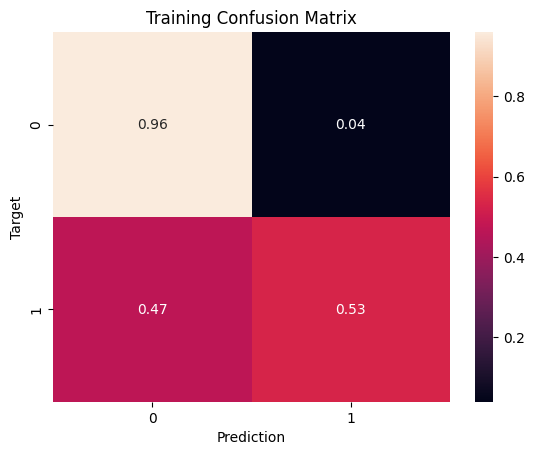

In [309]:
train_preds_cm = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.57%


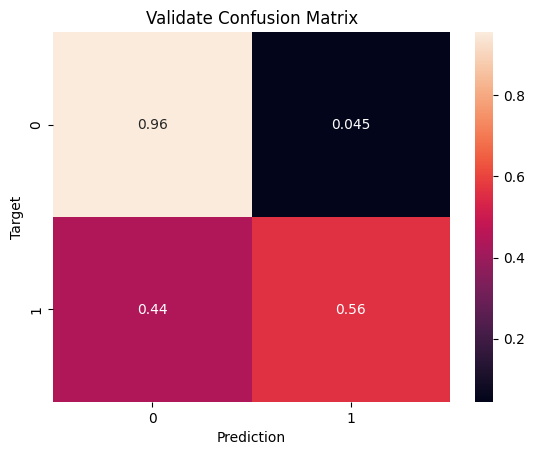

In [310]:
val_preds_cm = predict_and_plot(X_val, val_targets, 'Validate')

###Roc Curve, AUROC

AUROC for Training: 0.88


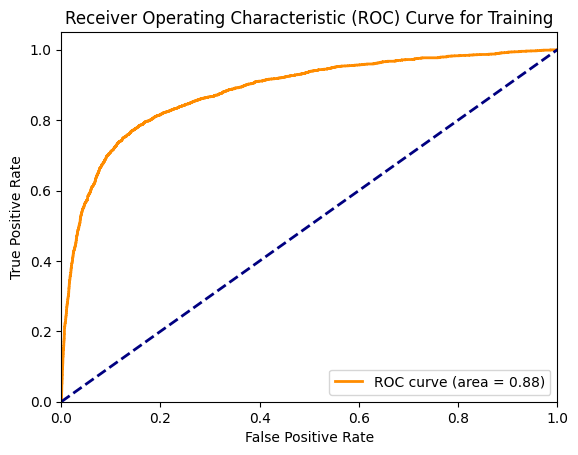

AUROC for Validation: 0.88


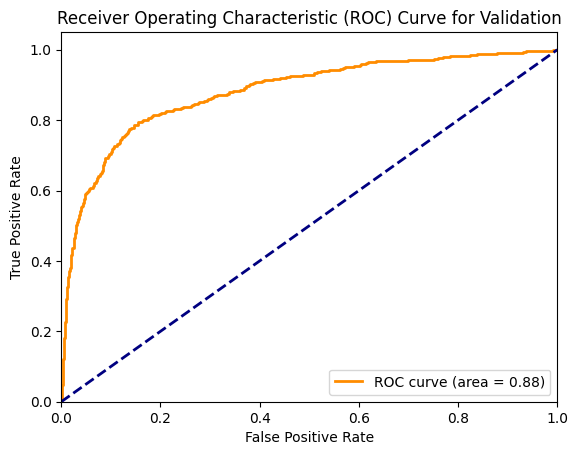

In [311]:
#ROC Curve
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

###F1 Score

In [312]:
get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.63%
F1 score Validation: 0.65%


**Відповідь:**
1. Оскільки логістична модель за замовчуванням будується з трешхолдом 0.5, додатково не використовувала predict_proba
2. Вважаю, що модель вийшла не погана, але ще потребує удосконалення

#8

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [313]:
train_targets.value_counts(normalize=True)

Exited
0.00   0.80
1.00   0.20
Name: proportion, dtype: float64

In [314]:
predict_0_t = predict_zero(X_train)
predict_0_v = predict_zero(X_val)
val_preds =  model.predict(X_val)

Accurancy

In [315]:
# 0_predict_model
#train
acc_0_t = accuracy_score(train_targets, predict_0_t)

#test
acc_0_v = accuracy_score(val_targets, predict_0_v)

#model_6
#train
acc_6_t = accuracy_score(train_targets, train_preds)

#test
acc_6_v = accuracy_score(val_targets, val_preds)

print (f'Train date: 0_predict = {acc_0_t:.3f}, model = {acc_6_t:.3f}')
print (f'Valid date: 0_predict = {acc_0_v:.3f}, model = {acc_6_v:.3f}')

Train date: 0_predict = 0.796, model = 0.873
Valid date: 0_predict = 0.797, model = 0.876


**Заключення:**
1. Створена модель краща ніж заповнення таргету мажоритарним класом.
2. Створена модель краще справляється на тестувальному наборі даних, аніж на тренувальному наборі

#9

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [317]:
bank_predict = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'asis_cols': asis_col,
    'encoded_cols': encoded_cols
}


In [318]:
joblib.dump(bank_predict, '//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/bank_predict.joblib')

['//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/bank_predict.joblib']

In [319]:
bank_pred2 = joblib.load('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/bank_predict.joblib')

In [320]:
val_preds2 = bank_pred2['model'].predict(X_val)
accuracy_score(val_targets, val_preds2)

0.8756666666666667

#10

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [322]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, asis_col, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [324]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, asis_col, df)

array([0.00737253, 0.03119693, 0.37033845, ..., 0.8927036 , 0.20854724,
       0.09789559])

#11

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [325]:
test_raw_df = pd.read_csv('//content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/test.csv')

In [326]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, asis_col, test_raw_df)

array([0.07977301, 0.03328172, 0.16336615, ..., 0.01883823, 0.16715317,
       0.09217655])

In [328]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, asis_col, test_raw_df)
test_raw_df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,15594796.00,Chu,-1.03,Germany,Male,-0.32,0.02,0.00,-0.33,1.00,1.00,-0.00,0.00,1.00,0.00,0.00,1.00,0.02
1,15001,15642821.00,Mazzi,-1.03,France,Male,-0.31,0.05,0.00,-0.22,1.00,1.00,-0.00,1.00,0.00,0.00,0.00,1.00,0.00
2,15002,15716284.00,Onyekachi,-1.03,France,Male,-0.31,0.08,0.00,-0.22,1.00,0.00,-0.00,1.00,0.00,0.00,0.00,1.00,0.01
3,15003,15785078.00,Martin,-1.03,Spain,Male,-0.31,0.03,0.00,-0.33,1.00,1.00,-0.00,0.00,0.00,1.00,0.00,1.00,0.00
4,15004,15662955.00,Kenechukwu,-1.03,Spain,Male,-0.31,0.08,0.00,-0.22,1.00,1.00,-0.00,0.00,0.00,1.00,0.00,1.00,0.00


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [330]:
ss = pd.read_csv('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/sample_submission.csv')

In [336]:
ss['Exited'] = ss['id'].map(test_raw_df.set_index('id')['Exited'])

In [338]:
ss.head(5)

,id,Exited
0,15000,0.02
1,15001,0.00
2,15002,0.01
3,15003,0.00
4,15004,0.00


In [339]:
ss.to_csv('/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/submission_log_reg.csv', index=False)